In [ ]:
# import libraries
import numpy as np
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Input, Activation, Dropout, Add, LSTM, GRU, RNN, LayerNormalization, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam,SGD
import tensorflow as tf
from keras import Model, regularizers, activations
import pickle
from copy import deepcopy
import random

# disable warnings to ignore overflow error
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [ ]:
# parameters for CSTR
T_0_cstr = 300
V_cstr = 1
k_0_cstr = 8.46*(np.power(10,6))
C_p_cstr = 0.231
rho_L_cstr = 1000
Q_s_cstr = 0.0
F_cstr = 5
E_cstr = 5*(np.power(10,4))
delta_H_cstr = -1.15*(np.power(10,4))
R_cstr = 8.314
C_A0s_cstr = 4

t_final_cstr = 0.005
t_step_cstr = 1e-4

# parameters for Batch
V_batch = 1
k_0_batch = 8.46*(np.power(10,7))
C_p_batch = 0.231
rho_L_batch = 1000
Q_s_batch = 0
E_batch = 5*(np.power(10,4))
delta_H_batch = -1.15*(np.power(10,4))
R_batch = 8.314

t_final_batch = 0.05
t_step_batch = 1e-4

# parameters for neural networks
num_step = 10
num_dims = 4

# parameters for Reptile
seed = 0
plot = True
rng = np.random.RandomState(seed)
innerstepsize = 0.02 # stepsize in inner SGD for reptile
innerepochs = 1 # number of epochs of each inner SGD
outerstepsize0 = 0.1 # stepsize of outer optimization, i.e., meta-optimization
niterations = 1000 # number of outer updates; each iteration we sample one task and update on it
epochs = 1 # number of epochs
ntrain = 32 # size of training minibatches (K)
eval_step = 50 # evaluation step
threshold = 10 # threshold to check data correctness

In [ ]:
def generate_new(x):
    return x + x * np.random.uniform(-10, 10)

def generate_new_small(x):
    return x + x * np.random.uniform(-0.05, 0.05)

def Batch_simulation(V, k_0, E, R, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial):
    """
        simulating Batch using forward Euler method
    """

    C_A_list = list()  # evolution of CA over time
    T_list = list()  # evolution of T over time

    C_A = C_A_initial
    T = T_initial

    for i in range(int(t_final / t_step)):
        dCAdt = -k_0 * np.exp(-E / (R * T)) * C_A
        dTdt = - delta_H / (rho_L * C_p) * k_0 * np.exp(-E / (R * T)) * C_A + Q / (rho_L * C_p * V)

        T += dTdt * t_step
        C_A += dCAdt * t_step

        if i % 50 == 0:
            C_A_list.append(C_A)
            T_list.append(T)

    return C_A_list, T_list

def CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial):
    """
        simulating CSTR using forward Euler method
    """

    C_A_list = list()  # evolution of CA over time
    T_list = list()  # evolution of T over time

    C_A = C_A_initial
    T = T_initial

    for i in range(int(t_final / t_step)):
        dCAdt = F / V * (C_A0 - C_A) - k_0 * np.exp(-E / (R * T)) * C_A**2
        dTdt = F / V * (T_0 - T) - delta_H / (rho_L * C_p) * k_0 * np.exp(-E / (R * T)) * C_A**2 + Q / (rho_L * C_p * V)

        T += dTdt * t_step
        C_A += dCAdt * t_step

        if i % 5 == 0:
            C_A_list.append(C_A)
            T_list.append(T)

    return C_A_list, T_list

def to_tensor(x):
    return tf.convert_to_tensor(x, dtype=tf.float32)

def train_on_batch(x, y, model, optimizer):
    x = to_tensor(x)
    y = to_tensor(y)

    with tf.GradientTape() as tape:
        YHat = model(x)
        loss = mse_loss_fn(y, YHat)
        grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss

def predict(x, model):
    x = to_tensor(x)
    return model(x).numpy()

def compute_loss(x, y, model):
    return np.square(predict(x, model) - y).mean()

In [ ]:
def gen_cstr(F, V, C_A0s, k_0, E, R, T_0, delta_H, rho_L, C_p, Q_s, t_final, t_step, num_step):
    isCorrect = False
    while isCorrect == False:
        T_0_new = generate_new(T_0)
        V_new = generate_new(V)
        F_new = generate_new(F)
        C_A0s_new = generate_new(C_A0s)
        Q_s_new = generate_new(Q_s)
        rho_L_new = generate_new_small(rho_L)
        C_p_new = generate_new_small(C_p)
        k_0_new = generate_new_small(k_0)
        E_new = generate_new_small(E)
        delta_H_new = generate_new_small(delta_H)

        # generating inputs and initial states for CSTR
        u1_list = np.linspace(-3.5, 3.5, 4, endpoint=True)
        u2_list = np.linspace(-5e5, 5e5, 4, endpoint=True)
        T_initial = np.linspace(300, 600, 20, endpoint=True)
        CA_initial = np.linspace(0, 6, 20, endpoint=True)

        # restruture the data
        T_start = list()
        CA_start = list()

        for T in T_initial:
            for CA in CA_initial:
                CA_start.append(CA)
                T_start.append(T)

        CA_start = np.array([CA_start])
        T_start = np.array([T_start])
        x_deviation = np.concatenate((CA_start.T, T_start.T), axis=1)

        # get X and y data for training and testing
        CA_output = list()
        T_output = list()
        CA_input = list()
        T_input = list()
        CA0_input = list()
        Q_input = list()

        for u1 in u1_list:
            C_A0 = u1 + C_A0s_new
            for u2 in u2_list:
                Q = u2 + Q_s_new
                for C_A_initial, T_initial in x_deviation:

                    C_A_list, T_list = CSTR_simulation(F_new, V_new, C_A0, k_0_new, E_new, R, T_0_new, delta_H_new, rho_L_new, C_p_new, Q, t_final, t_step, C_A_initial, T_initial)
                    if any(abs(i) < 0.001 for i in T_list) == False and any(abs(i) < 0.001 for i in C_A_list) == False and any(abs(i) > 10000 for i in T_list) == False and any(abs(i) > 10000 for i in C_A_list) == False and any(abs(i) == 0 for i in T_list) == False and any(abs(i) == 0 for i in C_A_list) == False and np.isnan(C_A_list).any() == False and np.isnan(T_list).any() == False and np.isinf(C_A_list).any() == False and np.isinf(T_list).any() == False:
                        CA0_input.append(u1)
                        Q_input.append(u2)
                        CA_input.append(C_A_initial)
                        T_input.append(T_initial)

                        CA_output.append(C_A_list)
                        T_output.append(T_list)

        # regenerate data if requirement is not met
        if len(CA_output) > 5000:

            # collate input for RNN
            CA0_input = np.array(CA0_input)
            CA0_input = CA0_input.reshape(-1,1,1)

            Q_input = np.array(Q_input)
            Q_input = Q_input.reshape(-1,1,1)

            CA_input = np.array(CA_input)
            CA_input = CA_input.reshape(-1,1,1)

            T_input = np.array(T_input)
            T_input = T_input.reshape(-1,1,1)

            RNN_input = np.concatenate((T_input, CA_input, Q_input, CA0_input), axis=2)
            RNN_input = RNN_input.repeat(num_step, axis=1)

            # collate output for RNN
            CA_output = np.array(CA_output)
            CA_output = CA_output.reshape(-1, num_step, 1)

            T_output = np.array(T_output)
            T_output = T_output.reshape(-1, num_step, 1)

            RNN_output = np.concatenate((T_output, CA_output), axis=2)

            # scale the data
            scaler_X = preprocessing.StandardScaler().fit(RNN_input.reshape(-1, num_dims))
            scaler_y = preprocessing.StandardScaler().fit(RNN_output.reshape(-1, 2))

            X = scaler_X.transform(RNN_input.reshape(-1, num_dims))
            y = scaler_y.transform(RNN_output.reshape(-1,2))

            if np.isnan(X).any() == False and np.isnan(y).any() == False and np.isinf(X).any() == False and np.isinf(y).any() == False and any(abs(i) > threshold for i in y.reshape(-1)) == False:
                isCorrect = True

    print("Number of training samples of CSTR: ", int(len(X)/num_step))
    return X.reshape(-1,num_step,num_dims), y.reshape(-1,num_step,2)

In [ ]:
def gen_batch(V, k_0, E, R, delta_H, rho_L, C_p, Q_s, t_final, t_step, num_step):
    isCorrect = False
    while isCorrect == False:
        V_new = generate_new(V)
        Q_s_new = generate_new(Q_s)
        rho_L_new = generate_new_small(rho_L)
        C_p_new = generate_new_small(C_p)
        k_0_new = generate_new(k_0)
        E_new = generate_new_small(E)
        delta_H_new = generate_new_small(delta_H)

        # generating inputs and initial states for Batch
        u_list = np.linspace(-5e5, 5e5, 4, endpoint=True)
        T_initial = np.linspace(300, 600, 40, endpoint=True)
        CA_initial = np.linspace(0, 6, 40, endpoint=True)

        # restruture the data
        T_start = list()
        CA_start = list()

        for T in T_initial:
            for CA in CA_initial:
                CA_start.append(CA)
                T_start.append(T)

        CA_start = np.array([CA_start])
        T_start = np.array([T_start])
        x_deviation = np.concatenate((CA_start.T, T_start.T), axis=1)

        # get X and y data for training and testing
        CA_output = list()
        T_output = list()
        CA_input = list()
        T_input = list()
        CA0_input = list()
        Q_input = list()

        for u1 in u_list:
            Q = u1 + Q_s_new
            for C_A_initial, T_initial in x_deviation:

                C_A_list, T_list = Batch_simulation(V_new, k_0_new, E_new, R, delta_H_new, rho_L_new, C_p_new, Q, t_final, t_step, C_A_initial, T_initial)
                if any(abs(i) < 0.001 for i in T_list) == False and any(abs(i) < 0.001 for i in C_A_list) == False and any(abs(i) > 10000 for i in T_list) == False and any(abs(i) > 10000 for i in C_A_list) == False and any(abs(i) == 0 for i in T_list) == False and any(abs(i) == 0 for i in C_A_list) == False and np.isnan(C_A_list).any() == False and np.isnan(T_list).any() == False and np.isinf(C_A_list).any() == False and np.isinf(T_list).any() == False:
                    CA0_input.append(0)
                    Q_input.append(u1)
                    CA_input.append(C_A_initial)
                    T_input.append(T_initial)

                    CA_output.append(C_A_list)
                    T_output.append(T_list)

        # regenerate data if requirement is not met
        if len(CA_output) > 5000:

            # collate input for RNN
            CA0_input = np.array(CA0_input)
            CA0_input = CA0_input.reshape(-1,1,1)

            Q_input = np.array(Q_input)
            Q_input = Q_input.reshape(-1,1,1)

            CA_input = np.array(CA_input)
            CA_input = CA_input.reshape(-1,1,1)

            T_input = np.array(T_input)
            T_input = T_input.reshape(-1,1,1)

            RNN_input = np.concatenate((T_input, CA_input, Q_input, Q_input), axis=2)
            RNN_input = RNN_input.repeat(num_step, axis=1)

            # collate output for RNN
            CA_output = np.array(CA_output)
            CA_output = CA_output.reshape(-1, num_step, 1)

            T_output = np.array(T_output)
            T_output = T_output.reshape(-1, num_step, 1)

            RNN_output = np.concatenate((T_output, CA_output), axis=2)

            # scale the data
            scaler_X = preprocessing.StandardScaler().fit(RNN_input.reshape(-1, num_dims))
            scaler_y = preprocessing.StandardScaler().fit(RNN_output.reshape(-1, 2))

            X = scaler_X.transform(RNN_input.reshape(-1, num_dims))
            y = scaler_y.transform(RNN_output.reshape(-1,2))

            if np.isnan(X).any() == False and np.isnan(y).any() == False and np.isinf(X).any() == False and np.isinf(y).any() == False and any(abs(i) > threshold for i in y.reshape(-1)) == False:
                isCorrect = True

    print("Number of training samples of Batch: ", int(len(X)/num_step))
    return X.reshape(-1,num_step,num_dims), y.reshape(-1,num_step,2)

In [ ]:
class Model(tf.keras.layers.Layer):

    def __init__(self):
        super(Model, self).__init__()

        self.layer_1 = SimpleRNN(64, activation='relu', return_sequences=True)
        self.layer_2 = SimpleRNN(64, activation='relu', return_sequences=True)
        self.layer_3 = Dense(2, activation='linear')

    def call(self, inputs):
        x = self.layer_1(inputs)
        x = self.layer_2(x)
        x = self.layer_3(x)
        return x

model = Model()

# Necessary to create the model's state.
# The model doesn't have a state until it's called at least once.
_ = model(tf.zeros((ntrain, num_step, num_dims)))

optimizer = tf.keras.optimizers.Adam()
mse_loss_fn = tf.keras.losses.MeanSquaredError()

In [ ]:
# generate testing cstr
isOverflow = True
while isOverflow == True:
    try:
        x_test_cstr, y_test_cstr = gen_cstr(F_cstr, V_cstr, C_A0s_cstr, k_0_cstr, E_cstr, R_cstr, T_0_cstr, delta_H_cstr, rho_L_cstr, C_p_cstr, Q_s_cstr, t_final_cstr, t_step_cstr, num_step)
        isOverflow = False
    except ValueError:
        pass

# generate testing batch
isOverflow = True
while isOverflow == True:
    try:
        x_test_batch, y_test_batch = gen_batch(V_batch, k_0_batch, E_batch, R_batch, delta_H_batch, rho_L_batch, C_p_batch, Q_s_batch, t_final_batch, t_step_batch, num_step)
        isOverflow = False
    except ValueError:
        pass

Number of training samples of CSTR:  6152
Number of training samples of Batch:  6240


In [ ]:
# # save the unseen datasets
# with open('x_test_cstr.pkl', 'wb') as f:
#     pickle.dump(x_test_cstr, f)

# with open('y_test_cstr.pkl', 'wb') as f:
#     pickle.dump(y_test_cstr, f)

# with open('x_test_batch.pkl', 'wb') as f:
#     pickle.dump(x_test_batch, f)

# with open('y_test_batch.pkl', 'wb') as f:
#     pickle.dump(y_test_batch, f)

In [ ]:
# load the unseen datasets
with open('x_test_cstr.pkl', 'rb') as f:
    x_test_cstr = pickle.load(f)

with open('y_test_cstr.pkl', 'rb') as f:
    y_test_cstr = pickle.load(f)

with open('x_test_batch.pkl', 'rb') as f:
    x_test_batch = pickle.load(f)

with open('y_test_batch.pkl', 'rb') as f:
    y_test_batch = pickle.load(f)

In [ ]:
model_reptile = pickle.load(open('model_reptile_cstr_batch.sav', 'rb'))
model_transfer = pickle.load(open('model_transfer_cstr_batch.sav', 'rb'))

In [ ]:
# k-shot learning on unseen task wrt 50 epochs per shot
test_loss_transfer_cstr = np.zeros(100)
test_loss_reptile_cstr = np.zeros(100)

# results on unseen cstr
for i in range(100):
    sample_idx = rng.choice(len(x_test_cstr), size=i+1)
    xtest_plot = x_test_cstr[sample_idx]
    ytest_plot = y_test_cstr[sample_idx]

    # transfer
    optimizer = tf.keras.optimizers.Adam()
    weights_before = deepcopy(model_transfer.get_weights())

    # k-shot learning with N epochs
    for inneriter in range(50):
        train_on_batch(xtest_plot, ytest_plot, model_transfer, optimizer)

    test_loss_transfer_cstr[i] = compute_loss(x_test_cstr, y_test_cstr, model_transfer)
    print("transfer loss: ", test_loss_transfer_cstr[i])

    model_transfer.set_weights(weights_before)

    # reptile
    optimizer = tf.keras.optimizers.Adam()
    weights_before = deepcopy(model_reptile.get_weights())

    # k-shot learning with N epochs
    for inneriter in range(50):
        train_on_batch(xtest_plot, ytest_plot, model_reptile, optimizer)

    test_loss_reptile_cstr[i] = compute_loss(x_test_cstr, y_test_cstr, model_reptile)
    print("reptile loss: ", test_loss_reptile_cstr[i])

    model_reptile.set_weights(weights_before)

transfer loss:  1.0068216286341232
reptile loss:  0.3349741052248969
transfer loss:  0.8894198821387814
reptile loss:  0.12062004733162474
transfer loss:  0.9924861804853301
reptile loss:  0.09825983129962461
transfer loss:  0.7701951325748652
reptile loss:  0.07818804137575261
transfer loss:  0.5262106890279598
reptile loss:  0.02616181544011492
transfer loss:  0.6355609351257452
reptile loss:  0.026461219836870137
transfer loss:  0.5637700478886212
reptile loss:  0.010270485007874716
transfer loss:  0.5299623594095846
reptile loss:  0.016674512389428887
transfer loss:  0.6935376664330669
reptile loss:  0.023617223992469218
transfer loss:  0.4380252457276478
reptile loss:  0.010748190765544516
transfer loss:  0.7613537678229086
reptile loss:  0.03812433074207617
transfer loss:  0.4334980862431071
reptile loss:  0.00810818470363763
transfer loss:  0.3898692602563366
reptile loss:  0.009480808464149844
transfer loss:  0.48456171252368824
reptile loss:  0.00831687998348093
transfer loss:

In [ ]:
# k-shot learning on unseen task wrt 50 epochs per shot
test_loss_transfer_batch = np.zeros(100)
test_loss_reptile_batch = np.zeros(100)

# results on unseen batch
for i in range(100):
    sample_idx = rng.choice(len(x_test_batch), size=i+1)
    xtest_plot = x_test_batch[sample_idx]
    ytest_plot = y_test_batch[sample_idx]

    # transfer
    optimizer = tf.keras.optimizers.Adam()
    weights_before = deepcopy(model_transfer.get_weights())

    # k-shot learning with N epochs
    for inneriter in range(50):
        train_on_batch(xtest_plot, ytest_plot, model_transfer, optimizer)

    test_loss_transfer_batch[i] = compute_loss(x_test_batch, y_test_batch, model_transfer)
    print("transfer loss: ", test_loss_transfer_batch[i])

    model_transfer.set_weights(weights_before)

    # reptile
    optimizer = tf.keras.optimizers.Adam()
    weights_before = deepcopy(model_reptile.get_weights())

    # k-shot learning with N epochs
    for inneriter in range(50):
        train_on_batch(xtest_plot, ytest_plot, model_reptile, optimizer)

    test_loss_reptile_batch[i] = compute_loss(x_test_batch, y_test_batch, model_reptile)
    print("reptile loss: ", test_loss_reptile_batch[i])

    model_reptile.set_weights(weights_before)

transfer loss:  0.18852812698458207
reptile loss:  0.27261544063813026
transfer loss:  0.1339607288882467
reptile loss:  0.17350772161518896
transfer loss:  0.1841678115137136
reptile loss:  0.28773697110228025
transfer loss:  0.09383726571125171
reptile loss:  0.1607050756705221
transfer loss:  0.13539617921625294
reptile loss:  0.10574412845251839
transfer loss:  0.10095999601840834
reptile loss:  0.044243682818073116
transfer loss:  0.06365321421659416
reptile loss:  0.1022822866023593
transfer loss:  0.11332784362452124
reptile loss:  0.11154915885788957
transfer loss:  0.09492252633123932
reptile loss:  0.09423682226103128
transfer loss:  0.06699288343113516
reptile loss:  0.03501606269632771
transfer loss:  0.0938765140634175
reptile loss:  0.05705531775348258
transfer loss:  0.057678858737693676
reptile loss:  0.035074813911421594
transfer loss:  0.06883456917355305
reptile loss:  0.02813770458767434
transfer loss:  0.04676794504458254
reptile loss:  0.021853637190251
transfer l

meta NOT subset; don't know how to subset; dropped


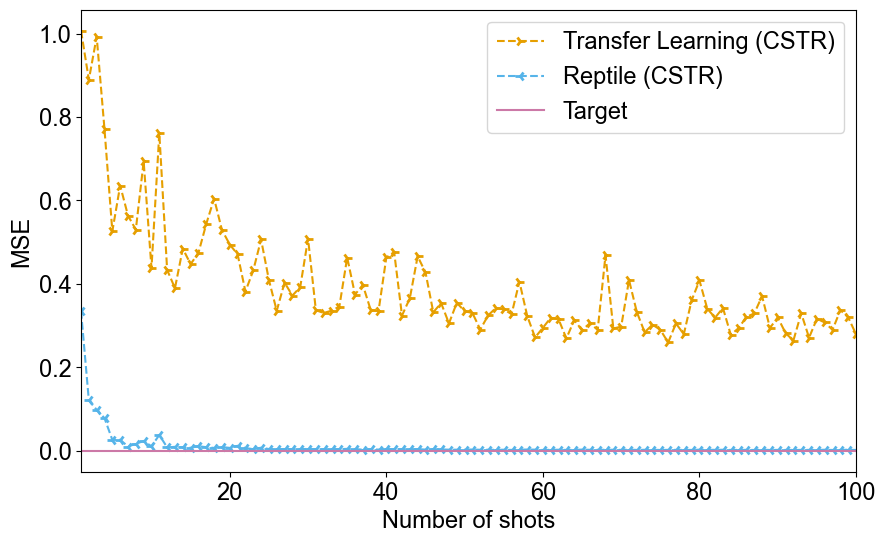

In [ ]:
# load packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# modify global setting
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

# Testing
test_loss_normal = [0.0001806485304716055]

size = 100
x = np.arange(1,size+1,1)

# color code: "#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"
plt.figure(figsize=(10,6))
plt.rc('font', size=17)
plt.plot(x, test_loss_transfer_cstr[:size], '--', color='#E69F00', marker='4', linewidth=1.5, markersize=7.5, markeredgewidth=2, label='Transfer Learning (CSTR)')
plt.plot(x, test_loss_reptile_cstr[:size], '--', color='#56B4E9', marker='3', linewidth=1.5, markersize=7.5, markeredgewidth=2, label='Reptile (CSTR)')
# plt.plot(x, test_loss_transfer_batch[:size], '--', color='#E69F00', marker='2', linewidth=1.5, markersize=10, markeredgewidth=2.5, label='Transfer Learning (Batch)')
# plt.plot(x, test_loss_reptile_batch[:size], '--', color='#56B4E9', marker='1', linewidth=1.5, markersize=10, markeredgewidth=2.5, label='Reptile (Batch)')
plt.plot(x, test_loss_normal*(size), color='#CC79A7', linewidth=1.5, label='Target')
plt.legend()
plt.xlabel("Number of shots")
plt.ylabel("MSE")
plt.margins(x=0)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.savefig('transfer_reptile_cstr.pdf')
plt.show()

meta NOT subset; don't know how to subset; dropped


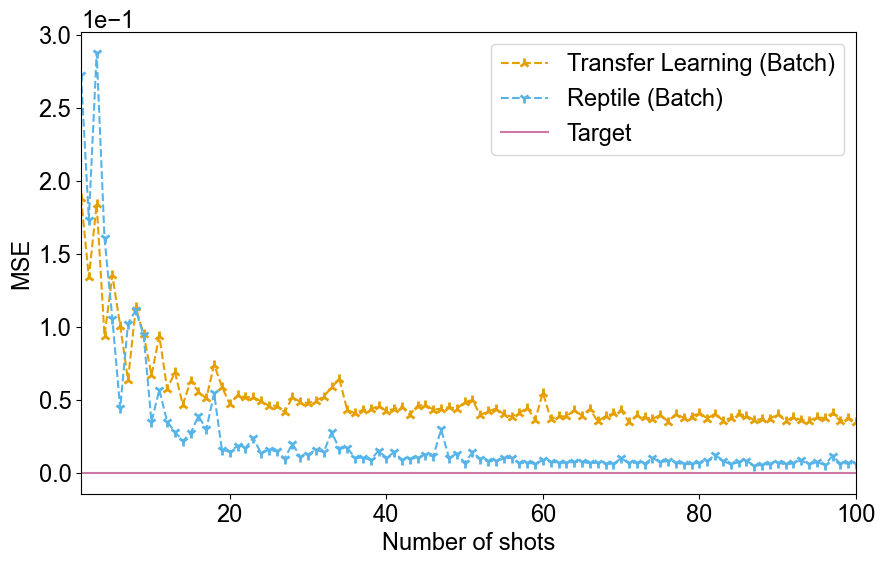

In [ ]:
# load packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# modify global setting
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

# Testing
test_loss_normal = [0.0001806485304716055]

size = 100
x = np.arange(1,size+1,1)

# color code: "#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"
plt.figure(figsize=(10,6))
plt.rc('font', size=17)
plt.plot(x, test_loss_transfer_batch[:size], '--', color='#E69F00', marker='2', linewidth=1.5, markersize=7.5, markeredgewidth=2, label='Transfer Learning (Batch)')
plt.plot(x, test_loss_reptile_batch[:size], '--', color='#56B4E9', marker='1', linewidth=1.5, markersize=7.5, markeredgewidth=2, label='Reptile (Batch)')
plt.plot(x, test_loss_normal*(size), color='#CC79A7', linewidth=1.5, label='Target')
plt.legend()
plt.xlabel("Number of shots")
plt.ylabel("MSE")
plt.margins(x=0)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.savefig('transfer_reptile_batch.pdf')
plt.show()

In [ ]:
for i in range(100):
    if (i+1) % 5 == 0:
        print("Test loss of transfer learning using %d-shots for CSTR: %f" % (i+1, test_loss_transfer_cstr[i]))
        print("Test loss of reptile using %d-shots for CSTR: %f" % (i+1, test_loss_reptile_cstr[i]))

Test loss of transfer learning using 5-shots for CSTR: 0.526211
Test loss of reptile using 5-shots for CSTR: 0.026162
Test loss of transfer learning using 10-shots for CSTR: 0.438025
Test loss of reptile using 10-shots for CSTR: 0.010748
Test loss of transfer learning using 15-shots for CSTR: 0.447341
Test loss of reptile using 15-shots for CSTR: 0.007321
Test loss of transfer learning using 20-shots for CSTR: 0.494290
Test loss of reptile using 20-shots for CSTR: 0.007029
Test loss of transfer learning using 25-shots for CSTR: 0.409388
Test loss of reptile using 25-shots for CSTR: 0.004290
Test loss of transfer learning using 30-shots for CSTR: 0.508478
Test loss of reptile using 30-shots for CSTR: 0.004367
Test loss of transfer learning using 35-shots for CSTR: 0.463288
Test loss of reptile using 35-shots for CSTR: 0.004677
Test loss of transfer learning using 40-shots for CSTR: 0.463361
Test loss of reptile using 40-shots for CSTR: 0.004466
Test loss of transfer learning using 45-sh

In [ ]:
for i in range(100):
    if (i+1) % 5 == 0:
        print("Test loss of transfer learning using %d-shots for Batch: %f" % (i+1, test_loss_transfer_batch[i]))
        print("Test loss of reptile using %d-shots for Batch: %f" % (i+1, test_loss_reptile_batch[i]))

Test loss of transfer learning using 5-shots for Batch: 0.135396
Test loss of reptile using 5-shots for Batch: 0.105744
Test loss of transfer learning using 10-shots for Batch: 0.066993
Test loss of reptile using 10-shots for Batch: 0.035016
Test loss of transfer learning using 15-shots for Batch: 0.063056
Test loss of reptile using 15-shots for Batch: 0.027213
Test loss of transfer learning using 20-shots for Batch: 0.047087
Test loss of reptile using 20-shots for Batch: 0.014702
Test loss of transfer learning using 25-shots for Batch: 0.046044
Test loss of reptile using 25-shots for Batch: 0.015990
Test loss of transfer learning using 30-shots for Batch: 0.047841
Test loss of reptile using 30-shots for Batch: 0.012485
Test loss of transfer learning using 35-shots for Batch: 0.043142
Test loss of reptile using 35-shots for Batch: 0.017350
Test loss of transfer learning using 40-shots for Batch: 0.042663
Test loss of reptile using 40-shots for Batch: 0.010479
Test loss of transfer lear

In [ ]:
# np.savetxt("test_loss_transfer_cstr.txt", test_loss_transfer_cstr, fmt='%f', delimiter=" ")
# np.savetxt("test_loss_reptile_cstr.txt", test_loss_reptile_cstr, fmt='%f', delimiter=" ")
# np.savetxt("test_loss_transfer_batch.txt", test_loss_transfer_batch, fmt='%f', delimiter=" ")
# np.savetxt("test_loss_reptile_batch.txt", test_loss_reptile_batch, fmt='%f', delimiter=" ")